In [ ]:
#1 UNE FOIS
# la biblithèque albumentations sert pour la data augmentation des radios
!pip install opencv-python-headless==4.5.2.52
!pip install -U albumentations
!pip install torch-summary


In [ ]:
#2

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import os
import pathlib
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader

     |████████████████████████████████| 38.2 MB 1.1 MB/s 
     |████████████████████████████████| 102 kB 4.9 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
# 3
# progress bar pour afficher l'avancement du training 
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

In [ ]:
# 4
# pour afficher la mémoire libre/utilisée de la GPU 
# pour lancer le training avec la taille des radios 1024 x 1024 , il faut vérifier que toute la mémoire de la GPU est libre sinon redémarrer l'environnement d'exécution.
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total // 1024 ** 2 }') 
print(f'free     : {info.free // 1024 ** 2 }')
print(f'used     : {info.used // 1024 ** 2 }') 

total    : 15109
free     : 15109
used     : 0


In [ ]:
# 5 
# dossier des images
dataset_directory = os.path.join(os.environ["HOME"], "/content/drive/MyDrive/PTRANS2/Dev/data/Verite_terrain")

/content/drive/MyDrive/PTRANS2/Dev/data/Verite_terrain


In [ ]:
# 6
# dossier des radios
images_directory = os.path.join(dataset_directory, "Radios")

'/content/drive/MyDrive/PTRANS2/Dev/data/Verite_terrain/Radios'

In [ ]:
# 7
# dossier des masques des coeurs
masks_directory = os.path.join(dataset_directory, "Vertebres")

'/content/drive/MyDrive/PTRANS2/Dev/data/Verite_terrain/Vertebres'

In [ ]:
# 8
# liste des fichiers des radios 
images_filenames = list(sorted(os.listdir(images_directory)))

['20180316122722.012345.18_processed.png',
 '20180327175802.012345.84.png',
 '20180329111213.012345.101_processed.png',
 '20180330105353.012345.114.png',
 '20180331102234.012345.139_processed.png',
 '20180412115616.012345.178_processed.png',
 '20180416185721.012345.196_processed.png',
 '20180417105738.012345.197_processed.png',
 '20180419100728.012345.206_processed.png',
 '20180423185243.012345.221.png']

In [ ]:
# 9
# mélange aléatoire des fichiers des radios 
random.seed(42)
random.shuffle(images_filenames)

In [ ]:
# 10 
# partage les radios en training set (294), validation set (10) et testing set (10 : 5 à partir du training set et 5 à partir du validation set)
train_images_filenames = images_filenames[:294]
val_images_filenames = images_filenames[294:]
test_images_filenames= train_images_filenames[:5] + val_images_filenames[-5:]
len(train_images_filenames),len(val_images_filenames),len(test_images_filenames)

(294, 10, 10)

In [ ]:
# 11
# transformation du tenseur des masques en tenseur de dimension 2 (c'est le 4ème canal: le canal alpha) avec des 1 à la place du coeur et des 0 par ailleurs.
def preprocess_mask(mask):        
        background = np.zeros_like(mask[:,:,3], dtype=float)
        mask_01= background + mask[:,:,3]
        mask_01[mask_01 < 225 ] = 0.0
        mask_01[mask_01 >= 225] = 1.0 

        return mask_01

Vieworks_Chien_4.jpg
(2560, 3072)


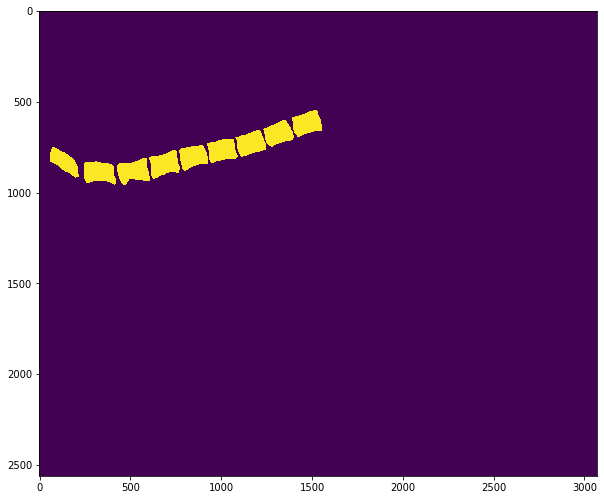

In [ ]:
#12 
# test de preprocess
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 24))
image_filename=train_images_filenames[4]
if image_filename.split('.')[1]=='jpg':
          mask_file=image_filename.replace(".jpg", ".png")
          mask = cv2.imread(os.path.join(masks_directory, mask_file), cv2.IMREAD_UNCHANGED,)
else:
          mask_file=image_filename
          mask = cv2.imread(os.path.join(masks_directory, mask_file), cv2.IMREAD_UNCHANGED,)

mask1=preprocess_mask(mask)
print(image_filename)
print(mask1.shape)

ax.imshow(mask1, interpolation="nearest")

In [ ]:
#13
#fonction pour approximer la valeur de la pos weight ( calcul de la proportion des 1 par rapport aux 0)
k=0
for i in range(mask1.shape[0]):
  #print("i= ",i)
  for j in range(mask1.shape[1]):
    if mask1[i,j] != 0.0:
      k +=1
pourcentage=k *100 /(mask1.shape[0]*mask1.shape[1])
                     
print("nombre de 1 ", k)
print("pourcentage ",pourcentage, " % ")
print("facteur ", (100-pourcentage)/pourcentage)

nombre de 1  15845
pourcentage  0.2770168822077712  % 
facteur  359.98882928368573


In [ ]:
# 14
# fonction pour afficher les 10 radios de test ainsi que leur masques vérités terrain
# on utilisera cette même fonction pour afficher les radios de test, ainsi que leurs masques vérités terrain et leur masques de prédiction.
plt.rcParams['figure.dpi'] = 80
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        
        if image_filename.split('.')[1]=='jpg':
          mask_file=image_filename.replace(".jpg", ".png")
          mask = cv2.imread(os.path.join(masks_directory, mask_file), cv2.IMREAD_UNCHANGED,)
        else:
          mask_file=image_filename
          mask = cv2.imread(os.path.join(masks_directory, mask_file), cv2.IMREAD_UNCHANGED,)

        mask = preprocess_mask(mask)   
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Image: " + image_filename +  " "+ ",".join(str(x) for x in image.shape) , fontsize=8)
        ax[i, 1].set_title("Ground truth mask: " + mask_file + " "+ ",".join(str(x) for x in mask.shape) , fontsize=8)
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation=None)
            ax[i, 2].set_title("Predicted mask" + " "+ ",".join(str(x) for x in predicted_mask.shape), fontsize=8 )
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

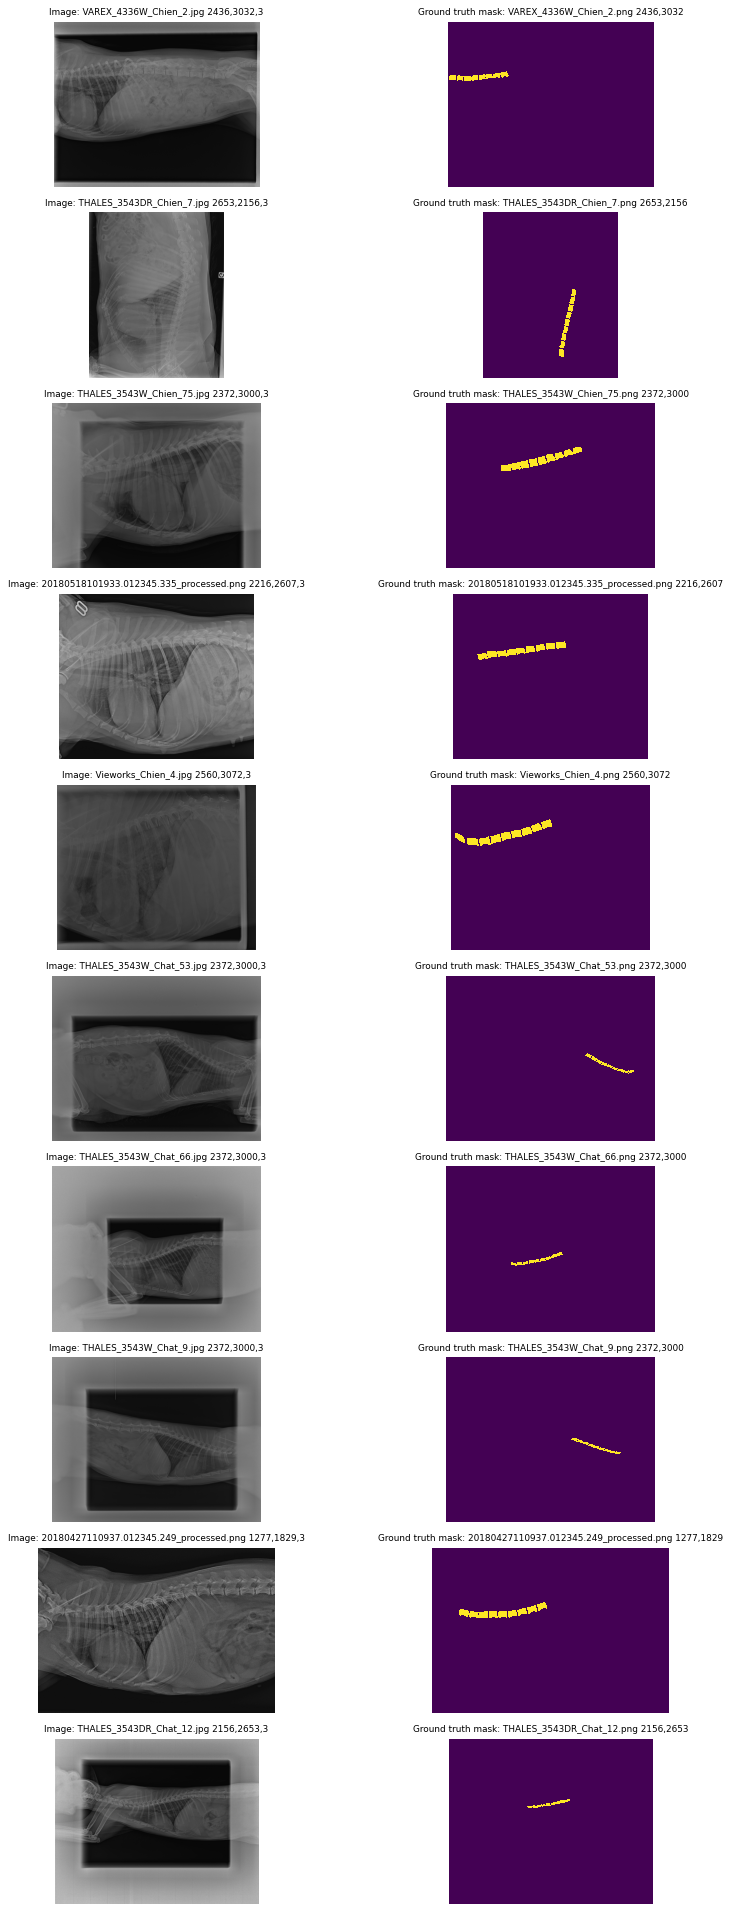

In [ ]:
display_image_grid(test_images_filenames, images_directory, masks_directory)

In [ ]:
# 15
# les transformations à appliquer à partir de la bibliothèque Albumentations qui vont servir à resize les radios et les masques en dimension unique 1024 x 1024 mais aussi à appliquer
# des transformations aléatoires pour la data augmentation.
# la data augmentation va nous permettre de pallier au nombre limité de radios (training set: 294) ,en effet en entrainant sur un nombre important d'epochs (200) et comme les transformations 
# sont aléatoires, c'est comme ci on avait un plus grand training set.

SIZE=1024

train_transform = A.Compose([
    A.LongestMaxSize(SIZE),
    A.PadIfNeeded(min_height=SIZE, min_width=SIZE, border_mode=cv2.BORDER_CONSTANT),
    A.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10,border_mode=cv2.BORDER_CONSTANT, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, brightness_by_max=True, always_apply=False, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()  
])


validation_transform = A.Compose([
    A.LongestMaxSize(SIZE),
    A.PadIfNeeded(min_height=SIZE, min_width=SIZE, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [ ]:
# 16
# la classe Dataset qui va permettre d'appliquer les transformations et surtout de créer le dataset qui servira à créer le dataloader , ce dernier alimentera le training.

class BuchananDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):

        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform



    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self,idx):
      
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))

        if image_filename.split('.')[1]=='jpg':
          mask_file=image_filename.replace(".jpg", ".png")
          mask = cv2.imread(os.path.join(masks_directory, mask_file), cv2.IMREAD_UNCHANGED,)
        else:
          mask_file=image_filename
          mask = cv2.imread(os.path.join(masks_directory, mask_file), cv2.IMREAD_UNCHANGED,)

        mask = preprocess_mask(mask)                                     # à l'emplacement du masque du coeur, on trouve 255 et elles sont converties en 1 et par ailleurs 0

        
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            radio = augmentations['image']
            target = augmentations['mask']
            
        return radio,target

In [ ]:
# 17 
train_dataset = BuchananDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)
val_dataset = BuchananDataset(val_images_filenames, images_directory, masks_directory, transform=validation_transform,)

In [ ]:
# 18
#fonction pour visualiser les transformations de la bibliothèque albumentations
def visualize_augmentations(dataset, idx=0, samples=10):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])

    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Augmented image" +  ",".join(str(x) for x in image.shape) )
        ax[i, 1].set_title("Augmented mask" + ",".join(str(x) for x in mask.shape) )
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

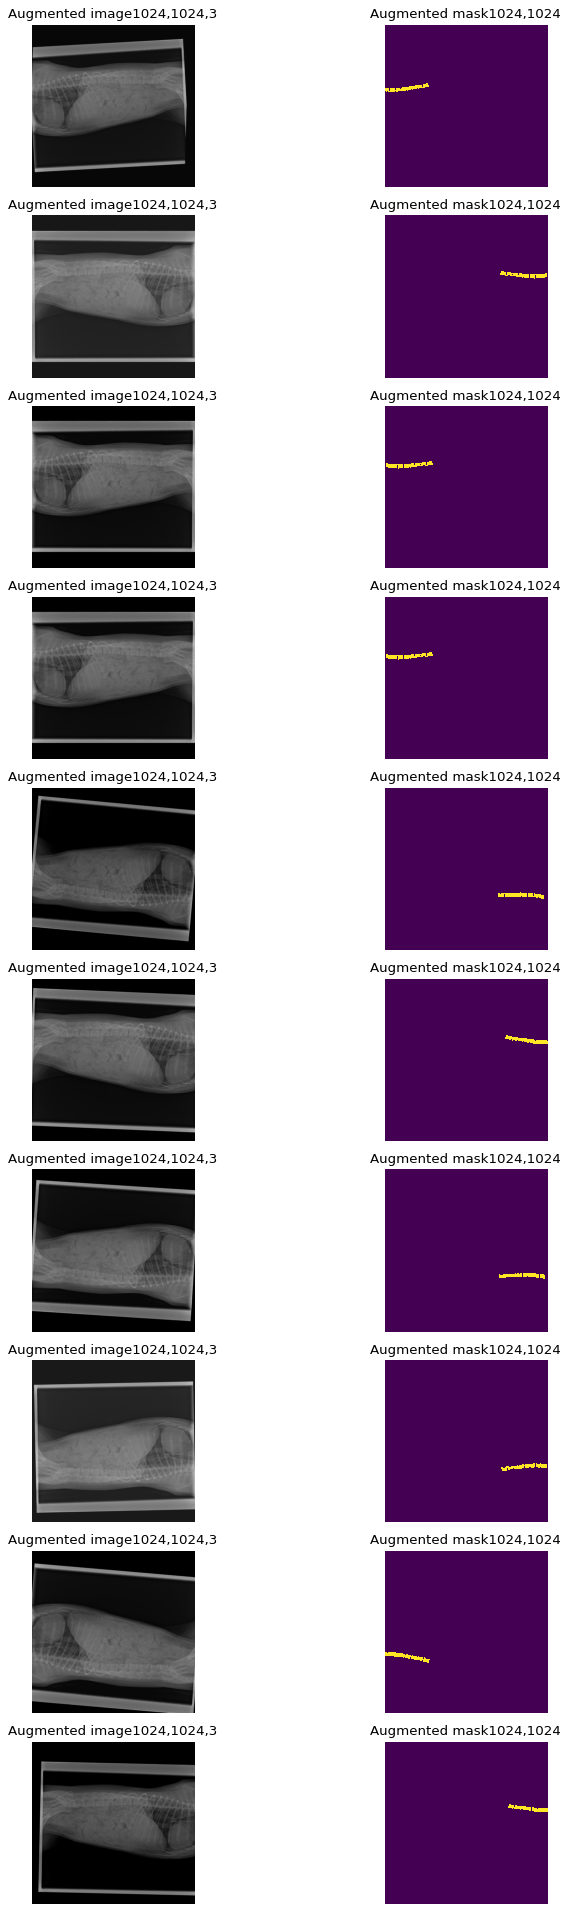

In [ ]:
# 19
#visualisation des transformations
random.seed(42)
plt.rcParams['figure.dpi'] = 80
visualize_augmentations(train_dataset, idx=0)

In [ ]:
# 20
# fonction pour afficher les informations du training durant son déroulement
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [ ]:
# 21
#fonction qui parcourt le réseau de neurones (forward et backward) : pour mettre à jour la fonction loss pour le train set et pour mettre à jour les poids 
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images).squeeze(1)
        loss = criterion(output, target)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [ ]:
# 22
# fonction qui parcourt le réseau de neurones pour mettre à jour la fonction loss pour le valdiation set
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images).squeeze(1)
            loss = criterion(output, target)
            metric_monitor.update("Loss", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [ ]:
#23
# nouveau modèle  avec 124 millions de paramètres
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
    return conv.to(DEVICE)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)


        self.down_conv_6 = double_conv(1024, 2048)
        
        self.up_trans_0 = nn.ConvTranspose2d(
            in_channels=2048,
            out_channels=1024,
            kernel_size=2,
            stride=2
        )
        self.up_conv_0 = double_conv(2048, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1
        )

    def forward(self, image):
        # expected size
        # encoder (Normal convolutions decrease the size)
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)        
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)  
        x10 = self.max_pool_2x2(x9)
        x11 = self.down_conv_6(x10)   
        # decoder (transposed convolutions increase the size)
        x = self.up_trans_0(x11)
        x = self.up_conv_0(torch.cat([x9, x], 1))                 
        x = self.up_trans_1(x9)
        x = self.up_conv_1(torch.cat([x7, x], 1))        
        x = self.up_trans_2(x)
        x = self.up_conv_2(torch.cat([x5, x], 1))
        x = self.up_trans_3(x)
        x = self.up_conv_3(torch.cat([x3, x], 1))
        x = self.up_trans_4(x)
        x = self.up_conv_4(torch.cat([x1, x], 1))
        x = self.out(x)
        return x.to(DEVICE)

In [ ]:
#24
#affichage du nouveau modèle
from torchsummary import summary
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(DEVICE)
summary(model, (3, 1024, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 64, 1024, 1024]           1,792
       BatchNorm2d-2       [-1, 64, 1024, 1024]             128
              ReLU-3       [-1, 64, 1024, 1024]               0
            Conv2d-4       [-1, 64, 1024, 1024]          36,928
       BatchNorm2d-5       [-1, 64, 1024, 1024]             128
              ReLU-6       [-1, 64, 1024, 1024]               0
         MaxPool2d-7         [-1, 64, 512, 512]               0
            Conv2d-8        [-1, 128, 512, 512]          73,856
       BatchNorm2d-9        [-1, 128, 512, 512]             256
             ReLU-10        [-1, 128, 512, 512]               0
           Conv2d-11        [-1, 128, 512, 512]         147,584
      BatchNorm2d-12        [-1, 128, 512, 512]             256
             ReLU-13        [-1, 128, 512, 512]               0
        MaxPool2d-14        [-1, 128, 2

In [ ]:
# 25
#fonction qui fait le training sur le training set et la validation sur le validation set en appellant les 2 fonctions "train" et "validate" 
def train_and_validate(model, train_dataset, val_dataset, params):
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    print("epochs : ", params["epochs"])
    
    # pos_weight parameter to balance the data between the classes 0 and 1 
    # For example, if a dataset contains 100 positive (1) and 300 negative (0) examples of a single class, 
    # then pos_weight for the class should be equal to 300/100=3.
    # The loss would act as if the dataset contains 3 x 100= 300 positive examples.
   
    weight = torch.full([1024, 1024], 20)  # pour les vertebres le facteur : nombre de 0 sur nombre de 1 est 200, a été réduit à 150, à la fin réduit à 100 et à 20
    criterion = nn.BCEWithLogitsLoss(pos_weight=weight).to(params["device"])
    
    #les traces des autres fonctions loss testées 

    # criterion = DiceLoss().to(params["device"])
    # criterion = DiceBCELoss().to(params["device"])
    # criterion = FocalLoss().to(params["device"])

    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    for epoch in range(1, params["epochs"] + 1):
        train(train_loader, model, criterion, optimizer, epoch, params)
        validate(val_loader, model, criterion, epoch, params)
    return model

In [ ]:
# 26
#fonction de prediction
def predict(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=params["num_workers"], pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions


In [ ]:
# 27
#les hyper paramètres des training
params = {
    "device": "cuda",
    "lr": 0.001,     
    "batch_size": 2,
    "num_workers": 2,
    "epochs": 50,
}

In [ ]:
DEVICE = params["device"]
model = UNet().to(DEVICE)

In [ ]:
# 28
# Unet 2048
# premier entrainement lancé avec 50 epochs
# BCE with logits
# pos_weight: 200
# lr 0.001 
model = train_and_validate(model, train_dataset, val_dataset, params)

epochs :  50


Epoch: 50. Validation. Loss: 0.978: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


In [ ]:
# 29
# enregistrement du modèle des l'entrainement fini
ROOT=pathlib.Path.cwd() / 'drive/MyDrive/PTRANS'
path_save=ROOT / "Dev/output/model_07052022_Vertebres_UNET_2048_BCEWL_epochs50.pth"
print(path_save)
torch.save(model, path_save)

/content/drive/MyDrive/PTRANS2/Dev/output/model_07052022_Vertebres_UNET_2048_BCEWL_epochs50.pth


In [ ]:
#30
# chargement du modèle pré entrainé pour continuer le training plus tard (50 puis 100 puis 150 etc..)
ROOT=pathlib.Path.cwd() / 'drive/MyDrive/PTRANS'
path_save=ROOT / "Dev/output/model_07052022_Vertebres_UNET_2048_BCEWL_epochs50.pth"
model= torch.load(path_save)
model.eval()

In [ ]:
#31
# la classe Dataset ci-dessous va permettre de faire les prédictions.
class BuchananPredictionDataset(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):

        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self,idx):
      
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        original_size = tuple(image.shape[:2])
        
        if self.transform is not None:
            augmentations = self.transform(image=image)
            radio = augmentations['image']
            
        return radio,original_size

In [ ]:
#32
# les transformations à appliquer au test set
test_transform = A.Compose([
    A.LongestMaxSize(SIZE),
    A.PadIfNeeded(min_height=SIZE, min_width=SIZE, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
test_dataset = BuchananPredictionDataset(test_images_filenames, images_directory, transform=test_transform,)

In [ ]:
#33
# Unet 2048
#dernier training qu'on a lancé 
# total 1 200 epochs à la fin du training 
# BCE with logits
# pos_weight: 20
# lr 0.001 
#vertebres
model = train_and_validate(model, train_dataset, val_dataset, params)

epochs :  50


Epoch: 50. Validation. Loss: 0.033: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


In [ ]:
#34
#enregistrement du dernier modèle obtenu
ROOT=pathlib.Path.cwd() / 'drive/MyDrive/PTRANS'
path_save=ROOT / "Dev/output/model_10052022_Vertebres_UNET_2048_BCEWL_epochs1200_posweight20.pth"
print(path_save)
torch.save(model, path_save)

/content/drive/MyDrive/PTRANS2/Dev/output/model_10052022_Vertebres_UNET_2048_BCEWL_epochs1200_posweight20.pth


In [ ]:
#35
# chargement du dernier modèle pré entrainé (après 1200 epochs) pour continuer le training plus tard avec plus d'epochs
ROOT=pathlib.Path.cwd() / 'drive/MyDrive/PTRANS'
path_save=ROOT / "Dev/output/model_10052022_Vertebres_UNET_2048_BCEWL_epochs1200_posweight20.pth"
model= torch.load(path_save)
model.eval()

In [ ]:
#36
predictions  = predict(model, params, test_dataset, batch_size=2)

In [ ]:
#37
# pour récupérer les dimensions d'origine des radios, des masques et des prédictions
predicted_masks = []
for predicted_1024x1024_mask, original_height, original_width in predictions:
    full_sized_mask = cv2.resize(        
        predicted_1024x1024_mask, (original_width,original_height), interpolation=cv2.INTER_NEAREST
    )
    predicted_masks.append(full_sized_mask)

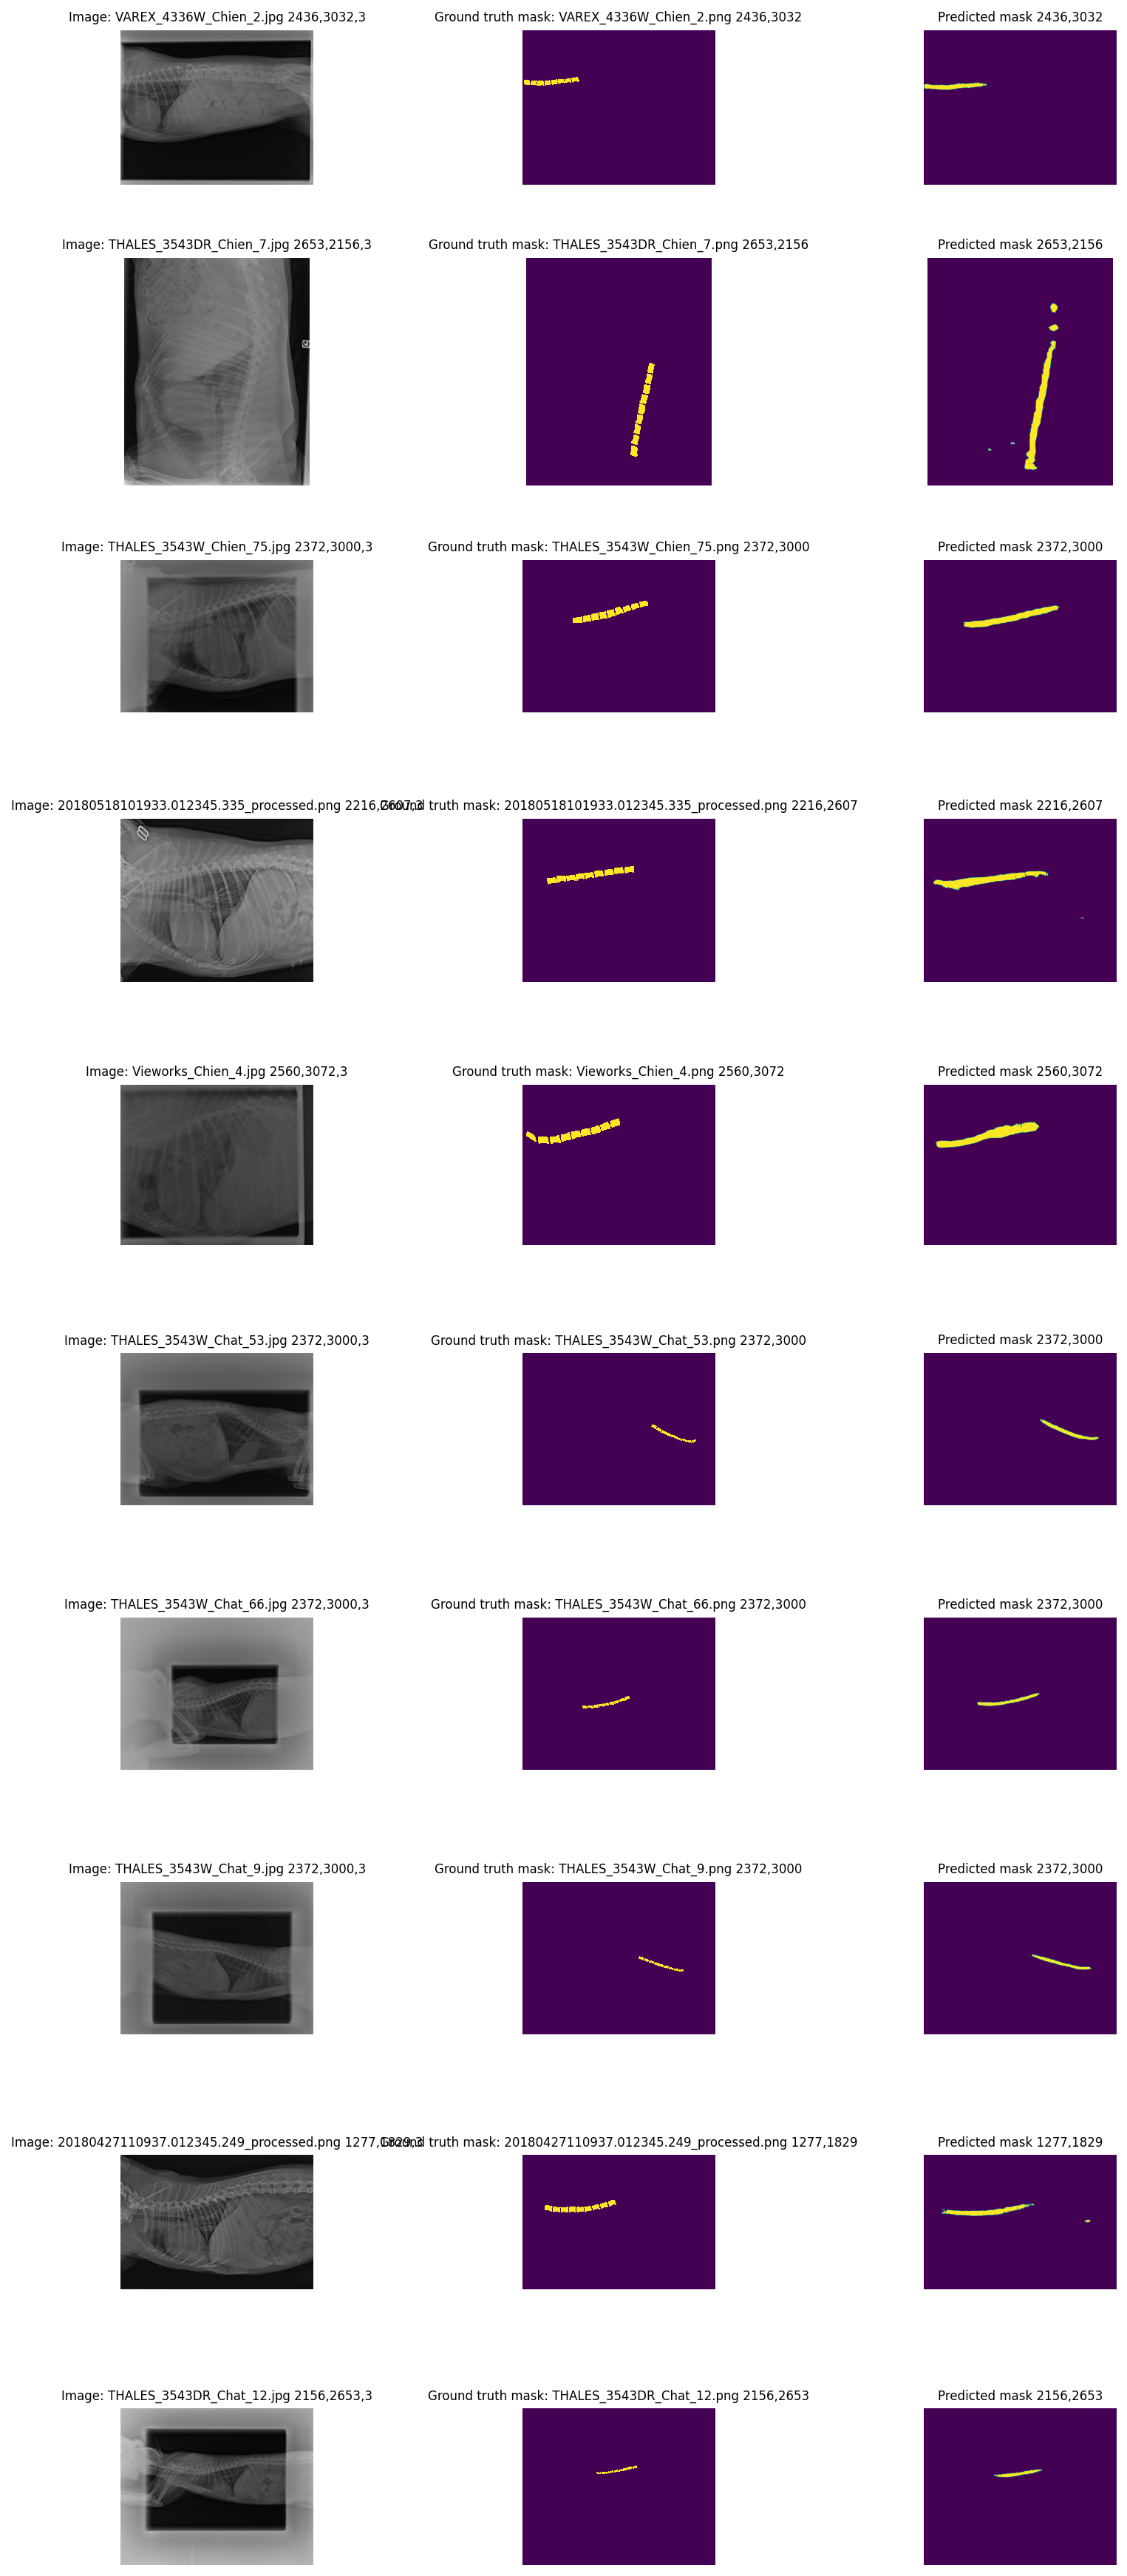

In [ ]:
# 38
# visualisation des prédictions du dernier réseau de neurones après 1200 epochs
# Unet 2048
# 1200 epochs
# BCE with logits
# pos_weight: 100
# lr 0.001 
# vertebres
plt.rcParams['figure.dpi'] = 150
display_image_grid(test_images_filenames, images_directory, masks_directory, predicted_masks=predicted_masks)